# Using transfer learning for large image classification

Exersice 10 from Chapter 14 of ML handsOn with scikit learn and tensorflow and keras by aegron

# Setup

In [7]:
import sys

assert sys.version_info >= (3, 7)

In [8]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [9]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [10]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

In [11]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Transfer Learning

In [1]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)
dataset_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [2]:
dataset_size

3670

In [3]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [4]:
n_classes

5

In [13]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    'tf_flowers',
    split=['train[:10%]', 'train[10%:25%]','train[25%:]'],
    as_supervised=True
)

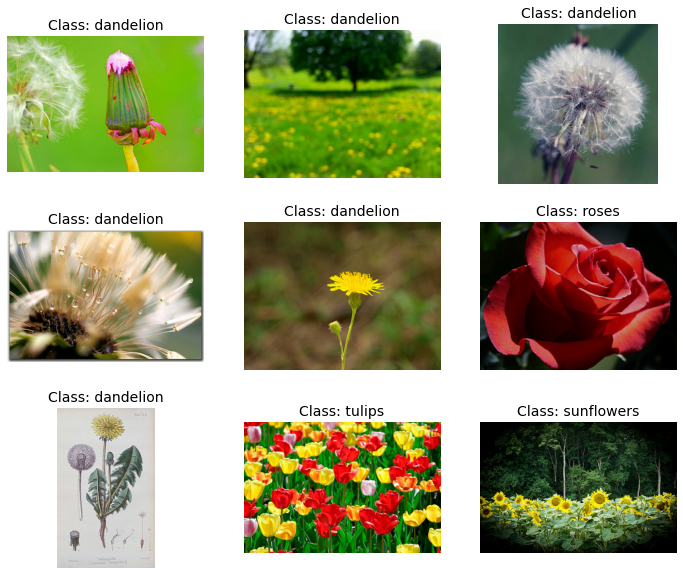

In [16]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

All three datasets contain individual images. We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a Resizing layer for this. We must also call the tf.keras.applications.xception.preprocess_input() function to preprocess the images appropriately for the Xception model. We will also add shuffling and prefetching to the training dataset.

In [17]:
tf.keras.backend.clear_session()

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

train_set = train_set_raw.map(lambda X,y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X,y: (preprocess(X), y)).batch(batch_size)
test_set  = test_set_raw.map(lambda X,y: (preprocess(X), y)).batch(batch_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Let's take a look again at the first 9 images from the validation set: they're all 224x224 now, with values ranging from -1 to 1:

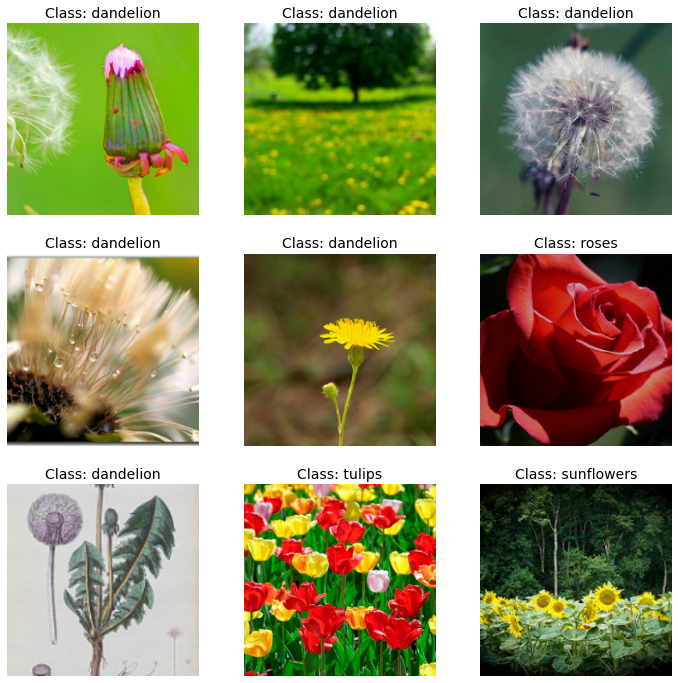

In [18]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [19]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

Try running the following cell multiple times to see different random data augmentations:

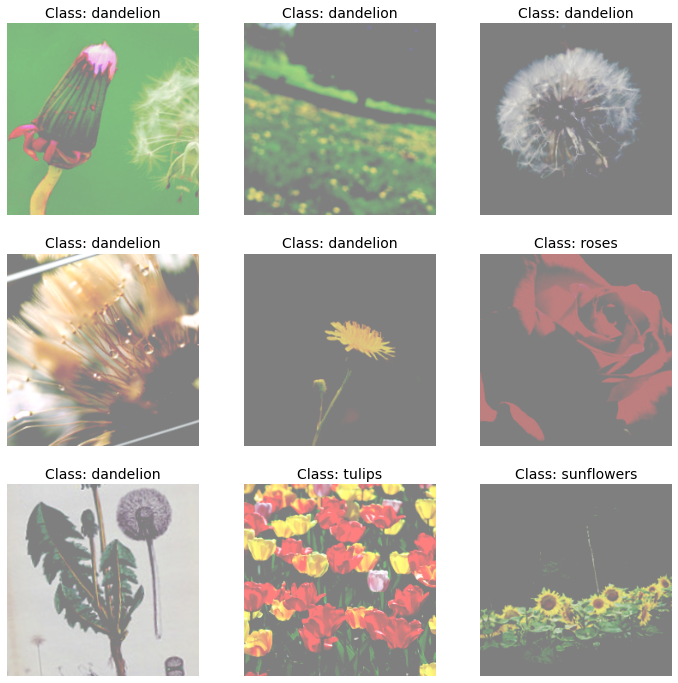

In [22]:
import numpy as np

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

Now let's load the pretrained model, without its top layers, and replace them with our own, for the flower classification task:

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

base_model = tf.keras.applications.xception.Xception(weights='imagenet',
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation='softmax')(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [27]:
for layer in base_model.layers:
  layer.trainable=False

Let's train the model for a few epochs, while keeping the base model weights fixed:

In [28]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 30s 180ms/step - loss: 0.7321 - accuracy: 0.8107 - val_loss: 0.7094 - val_accuracy: 0.8312
Epoch 2/3
86/86 [==============================] - 16s 169ms/step - loss: 0.3440 - accuracy: 0.9048 - val_loss: 0.5612 - val_accuracy: 0.8693
Epoch 3/3
86/86 [==============================] - 16s 171ms/step - loss: 0.1938 - accuracy: 0.9375 - val_loss: 0.5481 - val_accuracy: 0.8766


In [29]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
  for idx in indices:
    print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
  print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

Now that the weights of our new top layers are not too bad, we can make the top part of the base model trainable again, and continue training, but with a lower learning rate:

In [30]:
for layer in base_model.layers[56:]:
    layer.trainable = True

In [35]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 38s 330ms/step - loss: 0.2701 - accuracy: 0.9066 - val_loss: 0.5824 - val_accuracy: 0.8748
Epoch 2/10
86/86 [==============================] - 28s 313ms/step - loss: 0.0395 - accuracy: 0.9869 - val_loss: 0.4448 - val_accuracy: 0.8966
Epoch 3/10
86/86 [==============================] - 29s 325ms/step - loss: 0.0186 - accuracy: 0.9956 - val_loss: 0.3855 - val_accuracy: 0.9038
Epoch 4/10
86/86 [==============================] - 29s 321ms/step - loss: 0.0176 - accuracy: 0.9949 - val_loss: 0.3140 - val_accuracy: 0.9183
Epoch 5/10
86/86 [==============================] - 29s 323ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.2908 - val_accuracy: 0.9256
Epoch 6/10
86/86 [==============================] - 28s 322ms/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 0.3395 - val_accuracy: 0.9111
Epoch 7/10
86/86 [==============================] - 28s 319ms/step - loss: 0.0037 - accuracy: 0.9982 - val_loss: 0.3252 - val_accuracy: 0.9238